In [3]:
import numpy as np
import time

In [166]:
class RobotController:
    def __init__(self, Kp, Ki, dt=0.1, wheel_radius = 0.028, wheel_sep = 0.222, integral_windup=True, real_time=True):
        self.Kp = Kp            # Proportional gain
        self.Ki = Ki            # Integral gain
        self.dt = dt            # Time step
        
        self.r = wheel_radius
        self.l = wheel_sep
        
        self.min_output = -100  # Minimum duty cycle (-100%)
        self.max_output = 100  # Maximum duty cycle (100%)
        
        self.ml_integral = 0       # Integral term, motor left
        self.mr_integral = 0       # Integral term, motor right
        self.ml_last_update, self.mr_last_update = None, None  # Last update time

        self.anti_integral_windup = integral_windup  # Anti-windup flag
        self.real_time = real_time

    """
    Gets the time of the last measurement/update for the motor ml or mr
    """
    def get_dt(self, motor=None):
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")

        if not self.real_time:
            return self.dt
        
        last_update = f"{motor}_last_update"
        now = time.time()
        print(f"Last update: {getattr(self, last_update)}")
        if getattr(self, last_update) is None:
            setattr(self, last_update, now)
            return self.dt
        
        dt = now - getattr(self, last_update)
        setattr(self, last_update, now)
        return dt


    def compute(self, w_target, w_actual, motor=None):
        # motor should be either "ml" or "mr" for left or right motor
        if motor not in ['ml', 'mr']:
            raise ValueError("Motor must be 'ml' or 'mr'.")
        integral_attr = f"{motor}_integral"
        last_update = f"{motor}_last_update"
        
        dt = self.get_dt(motor)
        
        error = w_target - w_actual # Calculate the error
        P_out = self.Kp * error # Proportional term
        I_out = self.Ki * getattr(self,integral_attr) # Integral term
        raw_output = P_out + I_out

        if self.anti_integral_windup:
            # Anti-windup - only integrate if output is not saturated
            if self.min_output < raw_output < self.max_output:
                setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                # equiv. to self.ml_integral += error * self.dt or self.mr_integral += error * self.dt
        else:
            setattr(self, integral_attr, getattr(self, integral_attr) + error * dt)
                        
            
        return np.clip(raw_output, self.min_output, self.max_output) # Clamp the output to the min/max duty cycle limits
        
    
    def diff_drive_control(self, v_desired, w_desired, wl_actual, wr_actual):
        # v_desired: m/s
        # w_desired (rotation), wl_actual, w_actual (rotation): rad/s
        
        # Calculate desired wheel angular velocities
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
        print(f"wl_des (rad/s): {wl_desired:.2f}, wr_des: {wr_desired:.2f}\nwl_des (rps): {wl_desired/(2*np.pi):.2f}, wr_des: {wr_desired/(2*np.pi):.2f}")

        # Compute duty cycles for left and right wheels
        duty_cycle_l = self.compute(wl_desired, wl_actual, 'ml')
        duty_cycle_r = self.compute(wr_desired, wr_actual, 'mr')
        return duty_cycle_l, duty_cycle_r

# Example usage:
# Create a PI controller instance with desired Kp, Ki values and time step
Kp = 0.2  # Proportional gain
Ki = 0.02  # Integral gain
dt = 0.1  # Time step in seconds

controller = RobotController(Kp, Ki, dt)




# Compute the duty cycle to apply to the PWM motor


In [167]:
v_desired = 0.5
w_desired = 0
left_wheel_angvel = 0 # rad/s
right_wheel_angvel = 0 # rad/s

output = controller.compute(200, 200, 'mr')
print(f"Output: {output:.2f}")



duty_cycle_l, duty_cycle_r = controller.diff_drive_control(v_desired, w_desired, left_wheel_angvel, right_wheel_angvel)
print(f"Duty Cycle Left: {duty_cycle_l:.2f}%, Duty Cycle Right: {duty_cycle_r:.2f}%")

Last update: None
Output: 0.00
wl_des (rad/s): 17.86, wr_des: 17.86
wl_des (rps): 2.84, wr_des: 2.84
Last update: None
Last update: 1724581996.051604
Duty Cycle Left: 3.57%, Duty Cycle Right: 3.57%


In [1]:
import threading
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline
plt.ion()  # Turn on interactive mode

class Robot:
    def __init__(self):
        self.position = 0
        self.velocity = 0

    def update(self, control_input):
        self.velocity += control_input
        self.position += self.velocity

class RobotController:
    def __init__(self):
        self.robot = Robot()
        self.time = []
        self.positions = []
        self.velocities = []
        self.running = True

    def control_loop(self):
        start_time = time.time()
        while self.running:
            current_time = time.time() - start_time
            # Simulated control input (e.g., a sine wave)
            control_input = np.sin(current_time)
            
            # Update robot state
            self.robot.update(control_input)
            
            # Store data for plotting
            self.time.append(current_time)
            self.positions.append(self.robot.position)
            self.velocities.append(self.robot.velocity)
            
            # Simulate some processing time
            time.sleep(0.01)

    def start(self):
        self.control_thread = threading.Thread(target=self.control_loop)
        self.control_thread.start()

    def stop(self):
        self.running = False
        self.control_thread.join()

def update_plot(controller, fig, ax1, ax2):
    ax1.clear()
    ax2.clear()
    
    ax1.plot(controller.time, controller.positions)
    ax2.plot(controller.time, controller.velocities)
    
    ax1.set_ylabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_xlabel('Time')
    
    fig.canvas.draw()
    display.clear_output(wait=True)
    display.display(fig)



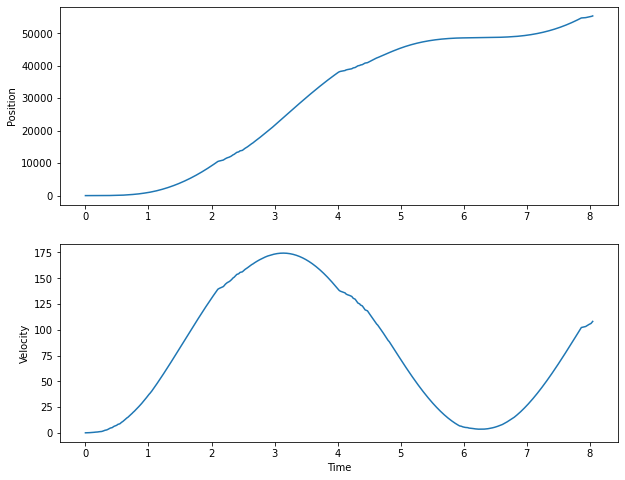

Stopping the simulation...
Simulation ended.


In [2]:
# Create the controller and start the control loop
controller = RobotController()
controller.start()

# Set up the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Main loop for updating the plot
try:
    while True:
        update_plot(controller, fig, ax1, ax2)
        time.sleep(1)  # Update plot every 0.1 seconds
except KeyboardInterrupt:
    print("Stopping the simulation...")
finally:
    controller.stop()
    plt.close(fig)

print("Simulation ended.")

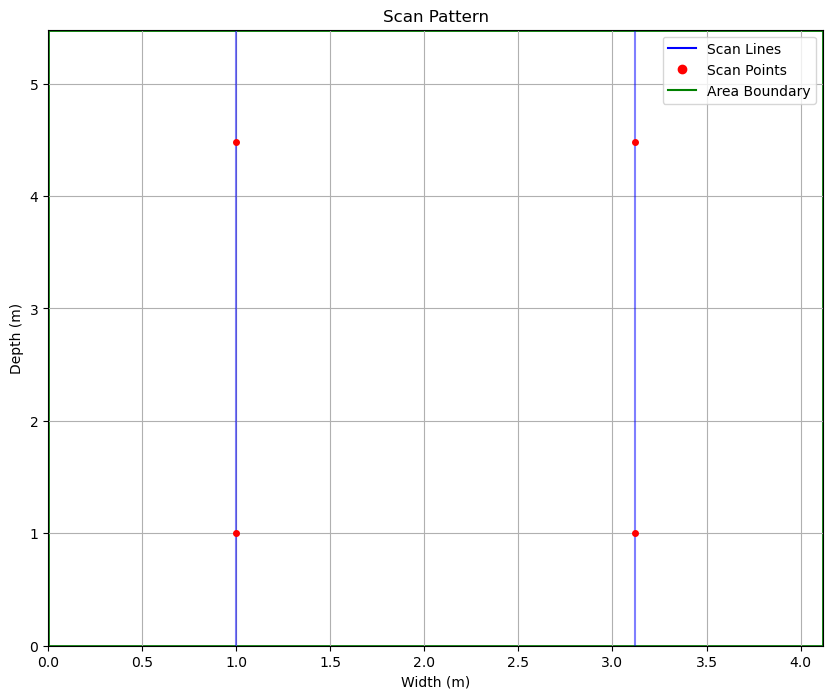

Number of scan lines: 2
Scan lines: [1.   3.12]
Number of scan points: 2
Scan points: [1.   4.48]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

def generate_scan_points(width, depth, max_scan_distance):
    scan_lines = np.arange(max_scan_distance, width - max_scan_distance + 0.01, 2 * max_scan_distance)
    scan_points = np.arange(max_scan_distance, depth - max_scan_distance + 0.01, 2 * max_scan_distance)
    return scan_lines, scan_points

def plot_scan_points(width, depth, scan_lines, scan_points, max_scan_distance):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot rectangle
    rect = Rectangle((0, 0), width, depth, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    
    # Plot scan points and circles
    for x in scan_lines:
        for y in scan_points:
            ax.scatter(x, y, color='blue', s=30)
            circle = Circle((x, y), max_scan_distance, fill=False, edgecolor='purple', alpha=0.5)
            ax.add_patch(circle)
    
    # Plot scan lines
    for x in scan_lines:
        ax.axvline(x, color='red', linestyle='--', alpha=0.5)
    
    # Set plot limits and labels
    ax.set_xlim(0, width)
    ax.set_ylim(0, depth)
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_title('Scan Points and Lines with Coverage Areas')
    
    # Add grid and legend
    ax.grid(True, linestyle=':')
    ax.legend([rect, plt.Line2D([0], [0], color='red', linestyle='--'),
               plt.Line2D([0], [0], marker='o', color='blue', linestyle='None'),
               Circle((0, 0), 1, fill=False, edgecolor='purple')],
              ['Area', 'Scan Lines', 'Scan Points', 'Scan Coverage'],
              loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Parameters
width = 4.12
depth = 5.48
max_scan_distance = 1.5

# Generate scan points and lines
scan_lines, scan_points = generate_scan_points(width, depth, max_scan_distance)

# Plot the results
plot_scan_points(width, depth, scan_lines, scan_points, max_scan_distance)

# Print information
print(f"Number of scan lines: {len(scan_lines)}")
print(f"Scan lines: {scan_lines}")
print(f"Number of scan points: {len(scan_points)}")
print(f"Scan points: {scan_points}")

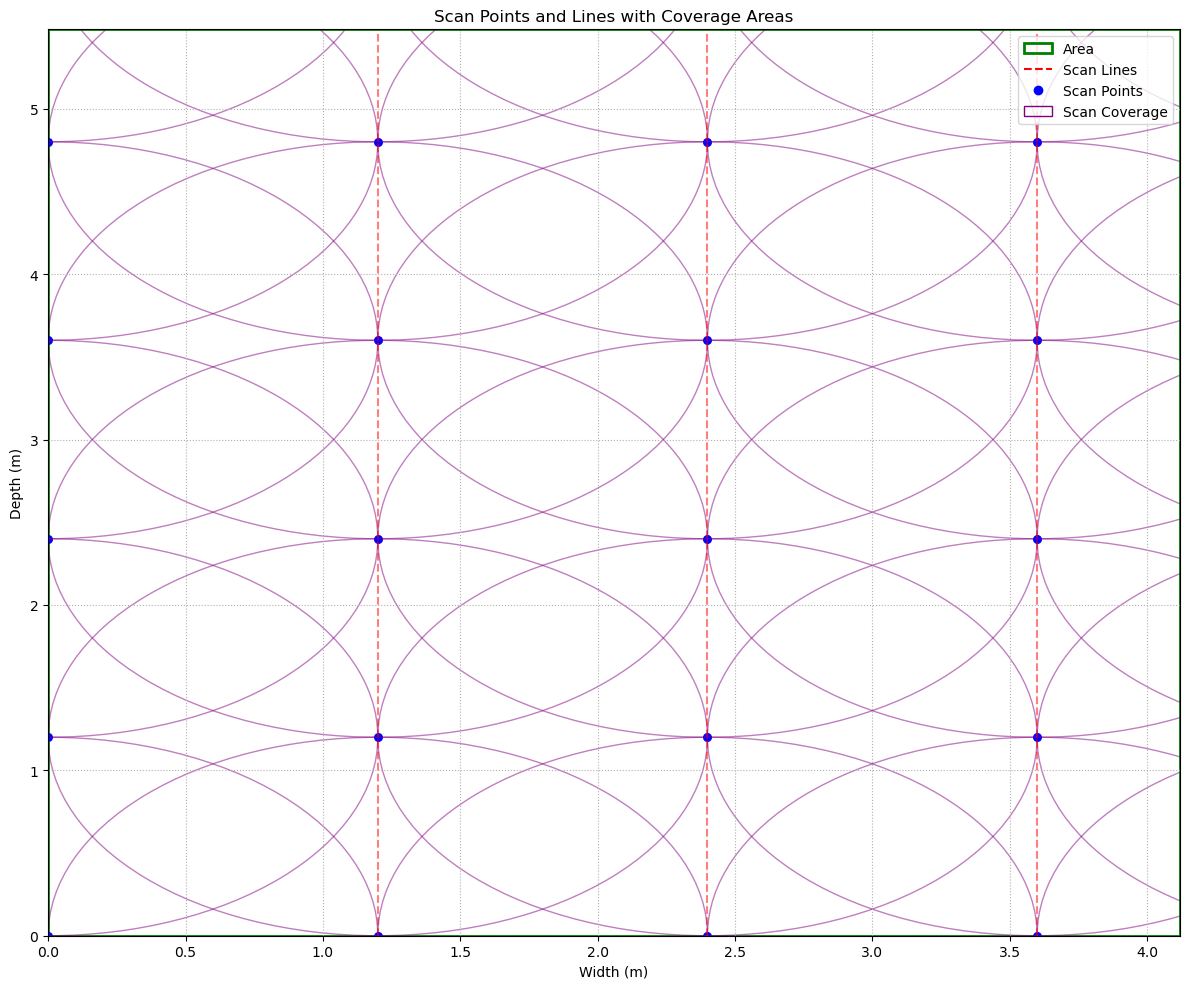

Number of scan lines: 5
Scan lines: [0.  1.2 2.4 3.6 4.8]
Number of scan points: 6
Scan points: [0.  1.2 2.4 3.6 4.8 6. ]


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

def generate_scan_points(width, depth, max_scan_distance, remove_points_on_boundary=False):
    scan_lines = np.arange(0, width + max_scan_distance, max_scan_distance)
    scan_points = np.arange(0, depth + max_scan_distance, max_scan_distance)
    
    # Clip the last points to ensure they don't exceed the rectangle dimensions
    # scan_lines = np.clip(scan_lines, 0, width)
    # scan_points = np.clip(scan_points, 0, depth)
    
    if remove_points_on_boundary:
        scan_lines = filter_array_inplace(scan_lines, 0, width)
        scan_points = filter_array_inplace(scan_points, 0, depth)
        
    return scan_lines, scan_points

def filter_array_inplace(arr, min_value, max_value):
    indices_to_remove = np.where((arr <= min_value) | (arr >= max_value))[0]
    return np.delete(arr, indices_to_remove)

def plot_scan_points(width, depth, scan_lines, scan_points, max_scan_distance):
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot rectangle
    rect = Rectangle((0, 0), width, depth, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)
    
    # Plot scan points and circles
    for x in scan_lines:
        for y in scan_points:
            ax.scatter(x, y, color='blue', s=30)
            circle = Circle((x, y), max_scan_distance, fill=False, edgecolor='purple', alpha=0.5)
            ax.add_patch(circle)
    
    # Plot scan lines
    for x in scan_lines:
        ax.axvline(x, color='red', linestyle='--', alpha=0.5)
    
    # Set plot limits and labels
    ax.set_xlim(0, width)
    ax.set_ylim(0, depth)
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_title('Scan Points and Lines with Coverage Areas')
    
    # Add grid and legend
    ax.grid(True, linestyle=':')
    ax.legend([rect, plt.Line2D([0], [0], color='red', linestyle='--'),
               plt.Line2D([0], [0], marker='o', color='blue', linestyle='None'),
               Circle((0, 0), 1, fill=False, edgecolor='purple')],
              ['Area', 'Scan Lines', 'Scan Points', 'Scan Coverage'],
              loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Parameters
width = 4.12
depth = 5.48
max_scan_distance = 1.2

# Generate scan points and lines
scan_lines, scan_points = generate_scan_points(width, depth, max_scan_distance)

# Plot the results
plot_scan_points(width, depth, scan_lines, scan_points, max_scan_distance)

# Print information
print(f"Number of scan lines: {len(scan_lines)}")
print(f"Scan lines: {scan_lines}")
print(f"Number of scan points: {len(scan_points)}")
print(f"Scan points: {scan_points}")

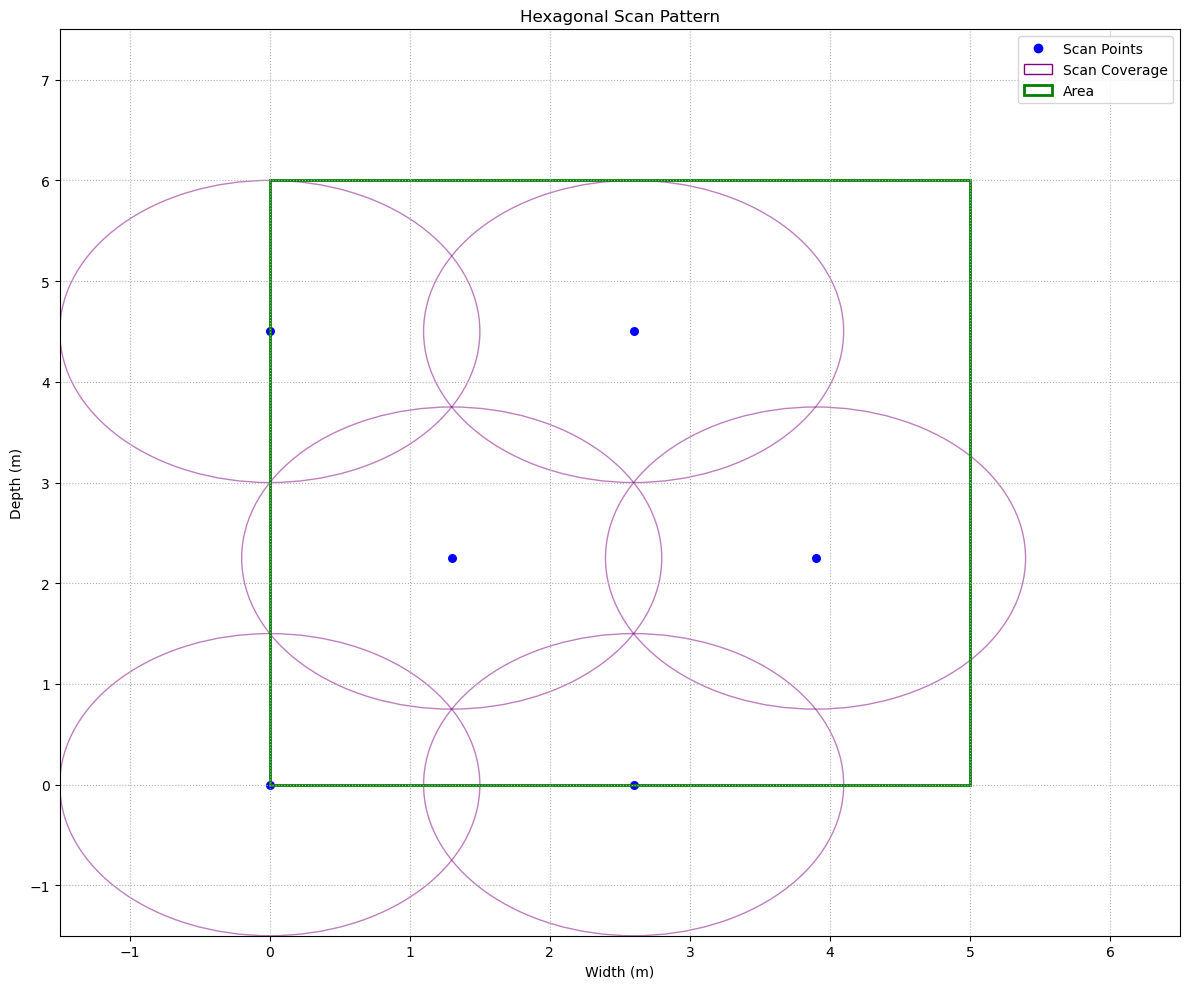

Number of scan points: 6
Scan points:
[[0.         0.        ]
 [2.59807621 0.        ]
 [1.29903811 2.25      ]
 [3.89711432 2.25      ]
 [0.         4.5       ]
 [2.59807621 4.5       ]]


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle

def generate_hexagonal_grid(width, depth, radius):
    # Calculate horizontal and vertical spacing
    dx = radius * np.sqrt(3)
    dy = radius * 1.5

    # Generate grid
    x = np.arange(0, width + dx, dx)
    y = np.arange(0, depth + dy, dy)

    # Create meshgrid
    xx, yy = np.meshgrid(x, y)

    # Offset every other row
    xx[1::2] += radius * np.sqrt(3) / 2

    # Flatten and combine coordinates
    points = np.column_stack((xx.ravel(), yy.ravel()))

    # Filter points outside the rectangle
    mask = (points[:, 0] >= 0) & (points[:, 0] <= width) & (points[:, 1] >= 0) & (points[:, 1] <= depth)
    return points[mask]

def plot_scan_pattern(width, depth, radius):
    fig, ax = plt.subplots(figsize=(12, 10))

    # Generate and plot hexagonal grid points
    points = generate_hexagonal_grid(width, depth, radius)
    ax.scatter(points[:, 0], points[:, 1], color='blue', s=30)

    # Plot circles for each point
    for x, y in points:
        circle = Circle((x, y), radius, fill=False, edgecolor='purple', alpha=0.5)
        ax.add_patch(circle)

    # Plot rectangle representing the area
    rect = Rectangle((0, 0), width, depth, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

    # Set plot limits and labels
    ax.set_xlim(-radius, width + radius)
    ax.set_ylim(-radius, depth + radius)
    ax.set_xlabel('Width (m)')
    ax.set_ylabel('Depth (m)')
    ax.set_title('Hexagonal Scan Pattern')

    # Add grid and legend
    ax.grid(True, linestyle=':')
    ax.legend([plt.Line2D([0], [0], marker='o', color='blue', linestyle='None'),
               Circle((0, 0), 1, fill=False, edgecolor='purple'),
               rect],
              ['Scan Points', 'Scan Coverage', 'Area'],
              loc='upper right')

    plt.tight_layout()
    plt.show()

    return points

# Parameters
# width = 4.12
# depth = 5.48

width =5
depth = 6

max_scan_distance = 1.5  # This is now the radius of each hexagon

# Generate and plot the hexagonal scan pattern
scan_points = plot_scan_pattern(width, depth, max_scan_distance)

# Print information
print(f"Number of scan points: {len(scan_points)}")
print(f"Scan points:\n{scan_points}")

In [ ]:
max_scan_distance = .8
num_scan_lines = int(np.ceil((width-(2*max_scan_distance)) / (2*max_scan_distance)))
scan_lines = np.linspace(max_scan_distance, width-max_scan_distance, num_scan_lines)
scan_lines = [-v for v in scan_lines]